# Tutorial 03: The ERPparam algorithm

This tutorial steps through the fitting procedure for ERPparam

In [7]:
# imports

# standard
import numpy as np

# ERPparam
import sys
sys.path.append('../')
from ERPparam.tests.tutils import default_params
from ERPparam.sim import simulate_erp
from ERPparam import ERPparam
from ERPparam.plts import plot_signals
from ERPparam.plts.annotate import plot_annotated_peak_search


In [5]:
# settings

# set the random seed for reproducibility
np.random.seed(4)

## Fitting Algorithm


Again, we will begin by simulating an example event-related potential (ERP), and we will fit a model on this simulated signal.

                                                                                                  
                                             ERP MODEL                                            
                                                                                                  
                                       2 peaks were found:                                        
                 Time:   0.09, Amp:   2.16, Dur:  0.08, Sym: 0.53, Sharp: 0.9773                  
                 Time:   0.20, Amp:  -1.32, Dur:  0.11, Sym: 0.40, Sharp: 0.9500                  
                                                                                                  
                                     Goodness of fit metrics:                                     
                                    R^2 of model fit is 0.8623                                    
                                    Error of the fit is 0.1353                                    
          

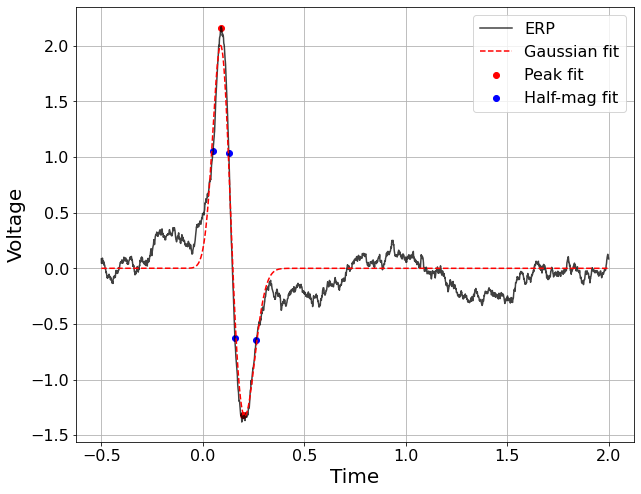

In [11]:
# simulate, fit, and plot an ERP

time_range, erp_params, nlv = default_params()
time, erp = simulate_erp(time_range, erp_params, nlv)

# fit model and plot
model = ERPparam(peak_threshold=5, gauss_overlap_thresh=3, min_peak_height=0.5)
model.report(time, erp)

Here, we see an illustration of the iterative fitting process, where each peak is fit using a gaussian, that guassian is subtract from the raw signal, and the process repeats. The iterative procedure halts when there are no more peaks which surpass the relative or absolute thresholds. 
The relative threshold (gold dashed lines) is calculated based off of the user-input hyperparameter setting `peak_threshold`, and relative to the `baseline` signal. The absolute threshold (red dashed lines) displays the threshold set by the `min_peak_height` setting.   

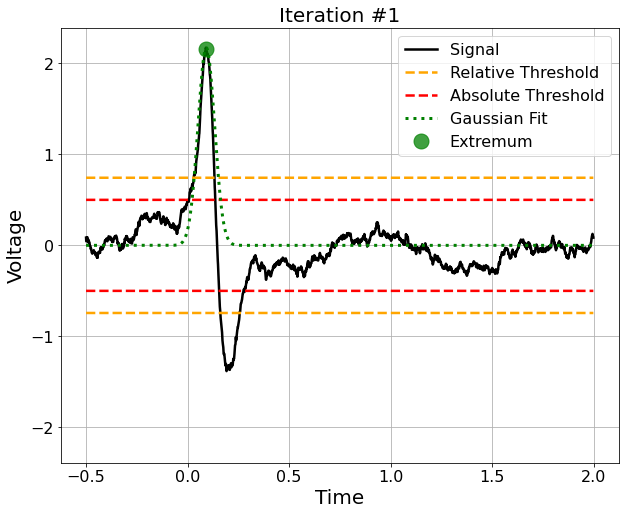

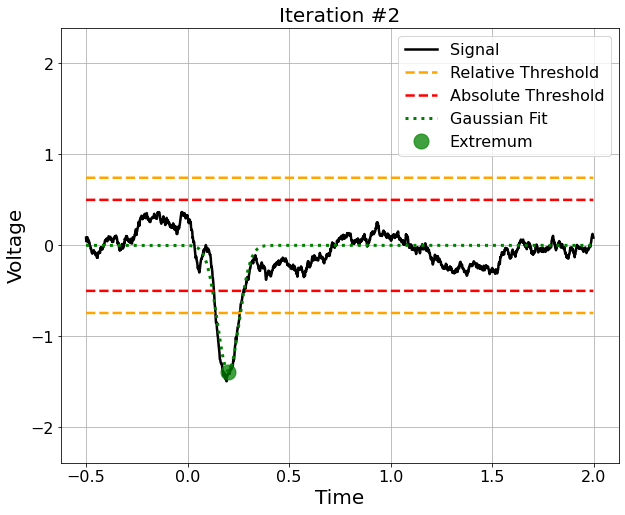

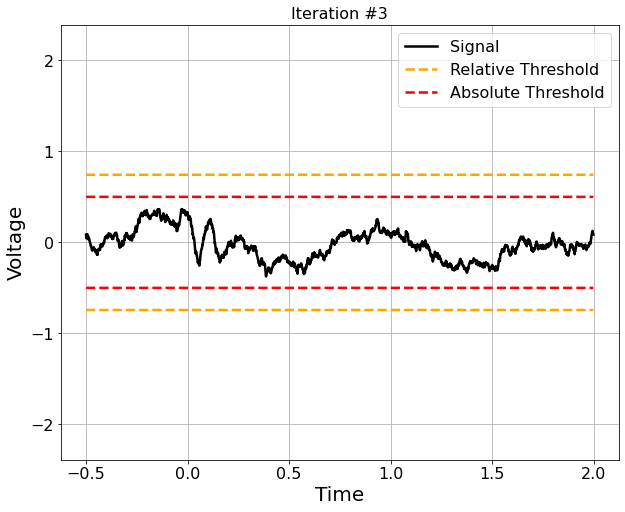

In [15]:
plot_annotated_peak_search(model)

The `model.fit()` function performs a set of checks for these gaussians, and calculates the shape parameters based on the finalized gaussian fits. If we look under the hood of the `fit()` function, we see a series of helper functions that should not be called explicitly by the user, but are explained here to elucidate the fitting algorithm.

 The raw signal is first input into the `model._generate_guess()` function, which takes in the raw signal, detects the maximum of the signal to use as the tentative guess of the gaussian center, and finds the full-width-half-maximum of the signal in order to approximate the gaussian bandwidth. The guessed gaussian height is calulcated as the value of the signal at the guess gaussian center. This procedure is repeated for both the positive and negative peaks:

In [ ]:
## outputs guess gaussian parameters, as [gaussian mean, height, and standard dev]
model._generate_guess(model.signal)

array([[0.09      , 2.17190179, 0.03227423]])

Next, in the `model._fit_peaks()` function, the series of guess gaussian peaks are checked for a series of criteria set by the user-defined hyperparameter settings, including for whether the peaks are too overlapping or too close to the edge of the signal. The guesses are then input to `scipy.curve_fit()` for the finalized gaussian fit, and checked again for whether they overlap or fall below the amplitude thresholds. 

In [ ]:
## finalized gaussian parameters for all peaks found in the signal
model._fit_peaks(model.signal)

array([[ 0.09230585,  2.17190179,  0.04093436,         nan],
       [ 0.2004544 , -1.38178102,  0.05394048,         nan]])

The finalized gaussian parameters are then used to calculate the shape parameters (`model._compute_shape_params()`). The gaussian fits are used to guide the search for the waveform features of the peak in the original signal. The peak latency and amplitude are calculated as the timing and height of the maximum of the signal between the gaussian FWHM points. The width of the signal is calculated as the distance (in time) between the peak start and end points. The rise and decay times are calculated as the distance (in time) between the peak center and the peak start, and the peak center and the peak end, respectively. The rise/decay symmetry reflects the proportion of the peak width which is spent in the rising phase of the peak. A perfectly symmetric peak, therefore, would have a value of 0.5. Lastly, the rise sharpness and decay sharpness are calculated as the relationship between the peak amplitude (the height at 50% of the total peak height) and the amount of time spect in the rising and falling phase of the signal. This approximates the angle of the rising and falling phase, respectively. The overall sharpness parameter is the mean of `sharpness_rise` and `sharpness_decay`.

In [17]:
## finalized shape parameters for each peak
model._compute_shape_params()

(array([[ 0.092     ,  2.16077761,  0.08186871,         nan,  0.077     ,
          0.041     ,  0.036     ,  0.53246753,  0.97732357,  0.97585231,
          0.97879482],
        [ 0.2       , -1.32218624,  0.10788095,         nan,  0.104     ,
          0.042     ,  0.062     ,  0.40384615,  0.95003922,  0.9596091 ,
          0.94046934]]),
 array([[551., 592., 628.],
        [658., 700., 762.]]))